In [4]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Drae a set of emitters and detectors

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def p1(w, h):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    x, y = 0, 0
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(xp, yp, w/4, h/4)
    ctx.rectangle(xp-w/4, yp-h/4, w/4, h/4)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def rotate_des(ds, es, angle):
    for d in ds:
        d['a'] += angle
    for e in es:
        e['a'] += angle
    return ds, es

[25046, 0, 0, 0, 0, 0, 0, 0, 0, 19757, 24514, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4019, 25054, 0, 0, 0, 0, 0, 0, 0, 0, 25363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13513, 0, 0, 0, 0, 0, 0, 0, 25524, 0, 0, 0, 0, 0, 0, 0, 14705]


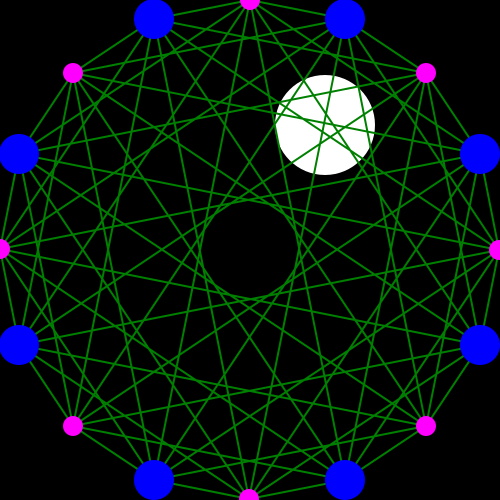

In [3]:
es = []
ds = []

for i in range(8):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi/2 + math.pi*(i+0.5)/4, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi*(i)/4, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)
# pd.DataFrame(ds)

tis, tii, x, y = test_image(500, 500, 50, 0.3, 0.5)
tis.write_to_png('ti.png')
Image('ti.png')

print(get_paths(tii, ds, es, 500, 500))

s = draw_des_surf(tis, ds, es, 500, 500)
s.write_to_png('ring_of_8_circle.png')
Image('ring_of_8_circle.png')

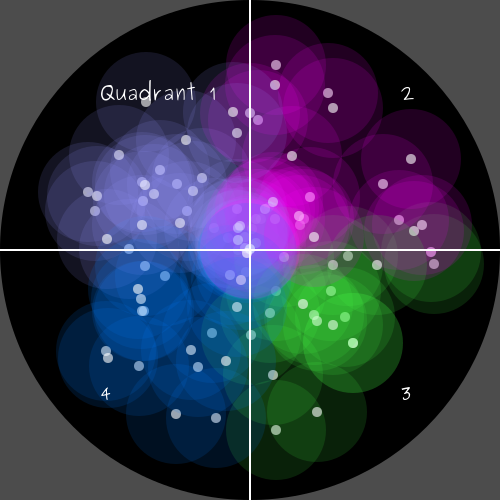

In [19]:
# vISUALIZING THE AREA WHERE WE'RE GENERATING SAMPLES (DIDN'T WANT TOO MUCH OVERLAP WITH THE EDGES)
w, h = 500, 500
surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
ctx = cairo.Context (surface)
ctx.set_source_rgb(0.3, 0.3, 0.3)
ctx.arc(250, 250,w,0,2*math.pi)
ctx.fill()
ctx.set_source_rgb(0, 0, 0)
ctx.arc(250, 250,w/2,0,2*math.pi)
ctx.fill()

r = 50

colors = [(1, 0, 1), (0.6, 0.6, 1), (0, 0.5, 1), (0.3, 1, 0.3)]

for i in range(100):
    radius = 0.2 + random.random()*0.55 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
    a = (rand*math.pi/2) + random.random()*math.pi/2 #math.pi/4 + rand*math.pi/2 + (random.random()*math.pi/4 - math.pi/8)
    x, y = radius*math.cos(a), radius*math.sin(a)
    xp, yp = point_to_pixel(x, y, w, h)
    ctx.set_source_rgba(*colors[rand], 0.13)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    ctx.set_source_rgba(1, 1, 1, 0.6)
    ctx.arc(xp, yp, 5, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    #tis, tii, x, y = test_image(500, 500, 50, r*math.cos(a), r*math.sin(a))

# Quadrant lines
ctx.set_source_rgb(1, 1, 1)
ctx.move_to(0, 250)
ctx.line_to(500, 250)
ctx.move_to(250, 0)
ctx.line_to(250, 500)

#Text
ctx.select_font_face("Purisa", cairo.FONT_SLANT_NORMAL, 
        cairo.FONT_WEIGHT_NORMAL)
ctx.set_font_size(20)
ctx.move_to(100, 100)
ctx.show_text("Quadrant 1")
ctx.move_to(400, 100)
ctx.show_text("2")
ctx.move_to(400, 400)
ctx.show_text("3")
ctx.move_to(100, 400)
ctx.show_text("4")

ctx.stroke()
ctx.fill()
    
buf  = np.frombuffer(surface.get_data(), np.uint8)
img = buf.reshape(w, h, 4)[:,:,0]
tis, tii = surface, img
fn = 'ring_of_8_full_overlap2.png'
tis.write_to_png(fn)
Image(fn)
    

In [21]:
# Generating test images one by one for training data
paths = []
quads = []
objs = []
for i in range(1500):
    r = 0.2 + random.random()*0.55 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
    a = rand*math.pi/2 + (random.random()*math.pi/2 - math.pi/4)
    tis, tii, x, y = test_image(500, 500, 50, r*math.cos(a), r*math.sin(a))
    path = get_paths(tii, ds, es, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
    paths.append(path)
    quads.append(rand)
    objs.append(0)
    
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths, quads)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)
mlpc.score(X_test, y_test)

# scores = []
# ns = []
# for i in range(10, 1000, 10):
#     mlpc = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
#     mlpc.fit(X_train[:i], y_train[:i])
#     scores.append(mlpc.score(X_test, y_test))
#     ns.append(i)


0.9626666666666667

Text(0,0.5,'Prediction Score')

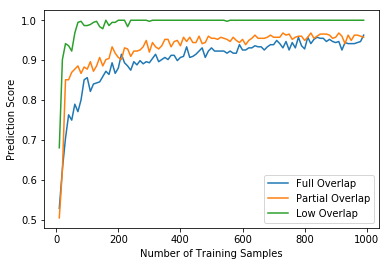

In [15]:
import pandas as pd
scores = pd.read_csv('scores_simulation_ring_of_8_overlap_varied.csv')
ax = scores.plot(x='Number of Samples')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Prediction Score')

# plt.plot(ns, scores1, label='Low Overlap')
# plt.plot(ns, scores2, label='Partial Overlap')
# plt.plot(ns, scores, label='Full Overlap')
# plt.legend()
# plt.ylabel('Predictio Score')
# plt.xlabel('Number of Samples')
# plt.savefig('ring_of_8_simulation.png')

# import pandas as pd
# sdf = pd.DataFrame({'Number of Samples':ns, 'Full Overlap':scores, 'Partial Overlap':scores2, 'Low Overlap':scores1})
# sdf.to_csv('scores_simulation_ring_of_8_overlap_varied.csv', index = False)

# Now doing position inference

In [16]:
X = []
Y = []

for i in range(1500):
    r = random.random()*0.75 # Get whole shape within circle
    a = random.random()*math.pi*2
    x, y = r*math.cos(a), r*math.sin(a)
    tis, tii, x, y = test_image(500, 500, 50, x, y)
    paths = get_paths(tii, ds, es, 500, 500)
    X.append(paths)
    Y.append([x, y])

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

mlpc.score(X_test, y_test)

0.8880322984129316

mean of errors: 0.0618642605645583
Standard deviation of errors: 0.062366950318757323


/home/jonathan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


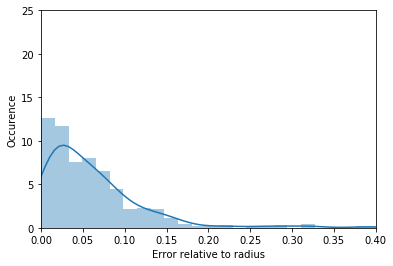

In [18]:
pred = mlpc.predict(X_test)
xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))
plt.savefig('ring_of_8_error_distribution_sim.png')

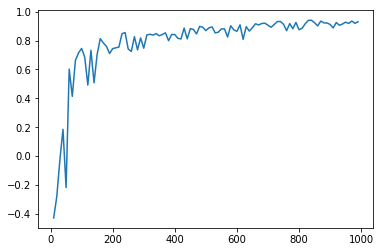

In [20]:
ns = []
scores = []
rmses = []
for i in range(1,100):
    mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlpc.fit(X_train[:i*10], y_train[:i*10])
    scores.append(mlpc.score(X_test, y_test))
    ns.append(i*10)
    rmse = math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))
    rmses.append(rmse)
    
plt.plot(ns, scores)

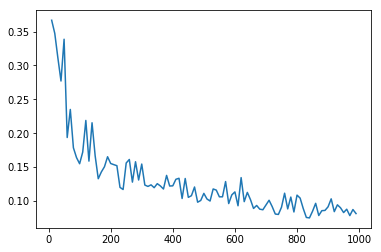

In [21]:
plt.plot(ns, rmses)
plt.savefig('ring_of_8_learning_rate_rmse_position_inference')

In [24]:
pred = mlpc.predict(X_test)
xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
s = 0
for e in ye:
    if e < 0.2:
        s += 1

print(s/len(ye))

0.9813333333333333


Loading our readings and using that as input... haven't I done this already?

In [5]:
import pandas as pd
r8 = pd.read_csv('posinf8_500_readings.csv')

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = r8[[str(i) for i in range(72)]]
y = r8['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

mlpc.score(X_test, y_test)

0.31387169236358203

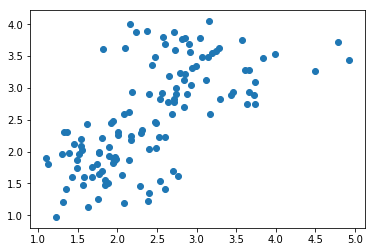

In [7]:
plt.scatter(mlpc.predict(X_test), y_test)

## Scrteatch that - pos_inf-r8 is a different notebook :)

# Doing reconstruction

This looks pretty sad...

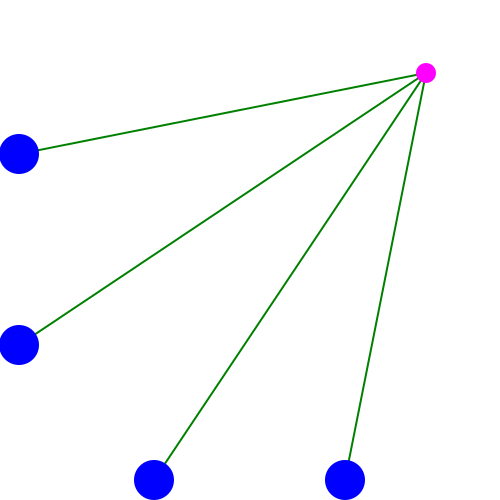

In [12]:
es = [{
        'r':1, # Distance from center relative to furthest object
        'a':math.pi/4, #2*math.pi*i/8,
    }]
ds = []

for i in range(1,5):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi/2 + math.pi*(i+0.5)/4, #2*math.pi*i/8,
    }
    
    ds.append(d)
    
s = draw_des(ds, es, 500, 500)
s.write_to_png('ring_of_8_recon.png')
Image('ring_of_8_recon.png')

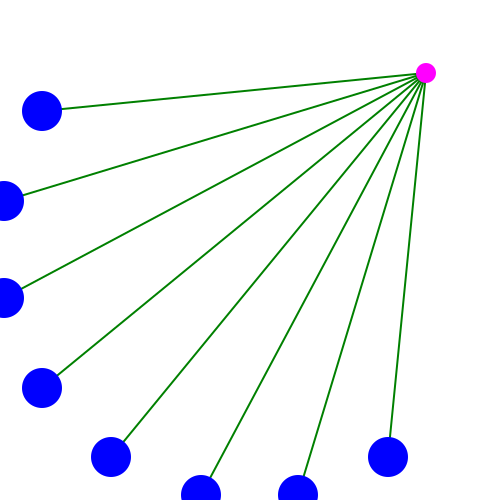

In [23]:
es = [{
        'r':1, # Distance from center relative to furthest object
        'a':math.pi/4, #2*math.pi*i/8,
    }]
ds = []

for i in range(2,10):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi/2 + math.pi*(i+0.5)/8, #2*math.pi*i/8,
    }
    
    ds.append(d)
    
s = draw_des(ds, es, 500, 500)
s.write_to_png('ring_of_8_recon.png')
Image('ring_of_8_recon.png')